## Including libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import pathlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


## Getting data from drive 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/TARP project/dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("/content")

In [4]:
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/TARP project/pred.zip", 'r') as zip_ref:
    zip_ref.extractall("/content")

## Set Path

In [26]:
data_dir = pathlib.Path("/content/dataset")

## Get Images what classify as having tumor

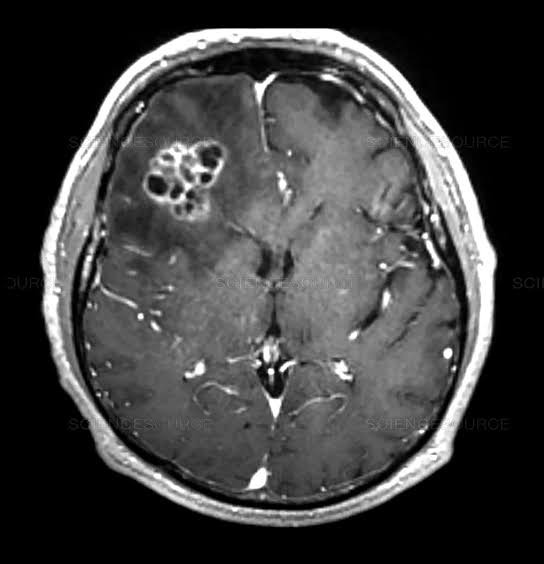

In [27]:
yes = list(data_dir.glob('yes/*'))
PIL.Image.open(str(yes[1]))

In [7]:
print(len(yes))

1500


## Get Images what classify as not having tumor

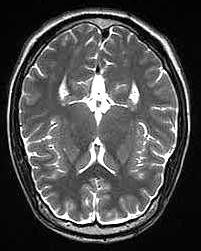

In [8]:
no = list(data_dir.glob('no/*'))
PIL.Image.open(str(no[1]))

In [9]:
print(len(no))

1500


## Set image properties

In [10]:
data_dir="/content/dataset"
batch_size = 32 #no. of samples processed before model updated
img_height = 180
img_width = 180

## Split In to training and Validation set

In [11]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3000 files belonging to 2 classes.
Using 2400 files for training.


In [12]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3000 files belonging to 2 classes.
Using 600 files for validation.


In [13]:
class_names = train_ds.class_names
print(class_names)

['no', 'yes']


## Check if dataset if is configured properly 

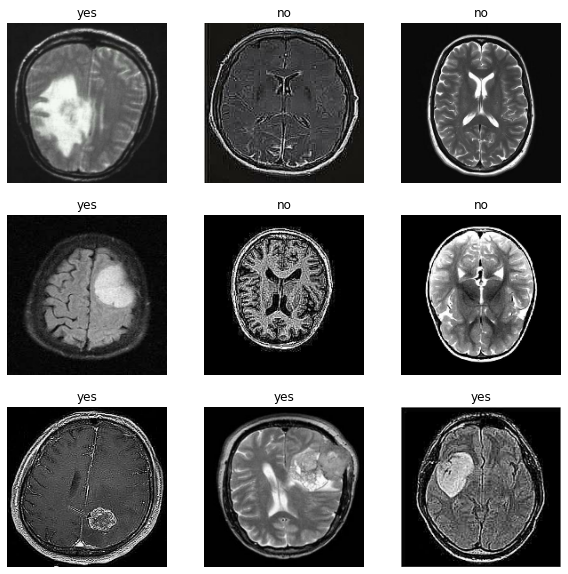

In [14]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Checking dimentions of data

In [15]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break
  #The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

(32, 180, 180, 3)
(32,)


In [16]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Model Buildiung

In [17]:
num_classes = len(class_names)

model1 = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Model Compilation

In [18]:
model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [20]:
epochs=10
history = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
75/75 [==============================] - 80s 1s/step - loss: 0.5471 - accuracy: 0.7513 - val_loss: 0.2906 - val_accuracy: 0.8850
Epoch 2/10
75/75 [==============================] - 74s 983ms/step - loss: 0.2389 - accuracy: 0.9021 - val_loss: 0.1995 - val_accuracy: 0.9217
Epoch 3/10
75/75 [==============================] - 74s 993ms/step - loss: 0.1231 - accuracy: 0.9563 - val_loss: 0.1349 - val_accuracy: 0.9550
Epoch 4/10
75/75 [==============================] - 74s 986ms/step - loss: 0.0568 - accuracy: 0.9825 - val_loss: 0.0867 - val_accuracy: 0.9867
Epoch 5/10
75/75 [==============================] - 75s 1000ms/step - loss: 0.0287 - accuracy: 0.9937 - val_loss: 0.0896 - val_accuracy: 0.9883
Epoch 6/10
75/75 [==============================] - 76s 1s/step - loss: 0.0117 - accuracy: 0.9971 - val_loss: 0.0977 - val_accuracy: 0.9850
Epoch 7/10
75/75 [==============================] - 83s 1s/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.1090 - val_accuracy: 0.9867
Epoch 8

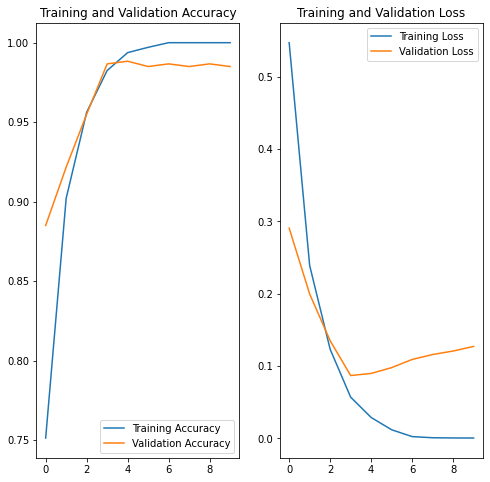

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [22]:
class_names_updated=["No Brain Tumor","Brain Tumor"]

This image most likely belongs to Brain Tumor with a 99.86 percent confidence.


(-0.5, 179.5, 179.5, -0.5)

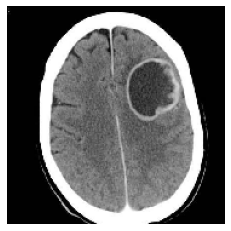

In [24]:
img_path="/content/pred/pred10.jpg"
img = tf.keras.utils.load_img(
    img_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model1.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names_updated[np.argmax(score)], 100 * np.max(score))
)
plt.imshow(img)
plt.axis("off")

## Data Augmentation if necessary

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

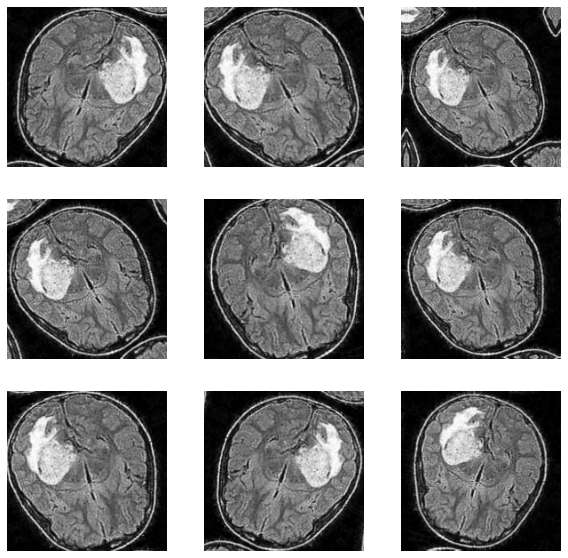

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
model2 = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs = 10
history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
75/75 [==============================] - 76s 1s/step - loss: 0.6348 - accuracy: 0.6908 - val_loss: 0.4575 - val_accuracy: 0.7933
Epoch 2/10
75/75 [==============================] - 75s 1s/step - loss: 0.4805 - accuracy: 0.7696 - val_loss: 0.3650 - val_accuracy: 0.8417
Epoch 3/10
75/75 [==============================] - 76s 1s/step - loss: 0.4392 - accuracy: 0.8058 - val_loss: 0.3552 - val_accuracy: 0.8517
Epoch 4/10
75/75 [==============================] - 74s 994ms/step - loss: 0.4120 - accuracy: 0.8112 - val_loss: 0.3358 - val_accuracy: 0.8900
Epoch 5/10
75/75 [==============================] - 75s 1s/step - loss: 0.3687 - accuracy: 0.8367 - val_loss: 0.3948 - val_accuracy: 0.8317
Epoch 6/10
75/75 [==============================] - 76s 1s/step - loss: 0.3360 - accuracy: 0.8537 - val_loss: 0.3163 - val_accuracy: 0.8833
Epoch 7/10
75/75 [==============================] - 76s 1s/step - loss: 0.3145 - accuracy: 0.8637 - val_loss: 0.3104 - val_accuracy: 0.8850
Epoch 8/10
75/75 

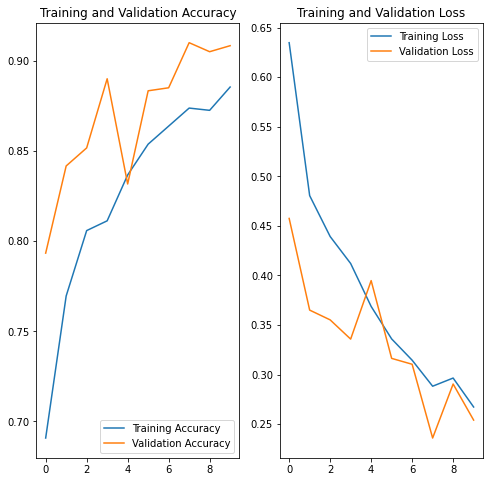

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()